In [45]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [46]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
feature_of_interest = "activeTTS_wstrand.bed"
# feature_of_interest = "allTTS_wstrand.bed"

In [49]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


In [50]:
# turn G4-seq data into bigBED files to plot them in the form of stackups as well ...

# save DataFrame as Bed:
fname = "G4_minus_polstall"
_df = G4_minus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_plus_polstall"
_df = G4_plus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_polstall"
_df = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb



pass1 - making usageList (22 chroms): 29 millis
pass2 - checking and writing primary data (195394 records, 3 fields): 200 millis
pass1 - making usageList (22 chroms): 33 millis
pass2 - checking and writing primary data (198824 records, 3 fields): 234 millis
pass1 - making usageList (22 chroms): 60 millis
pass2 - checking and writing primary data (378344 records, 3 fields): 414 millis


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [51]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end","strand"]
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


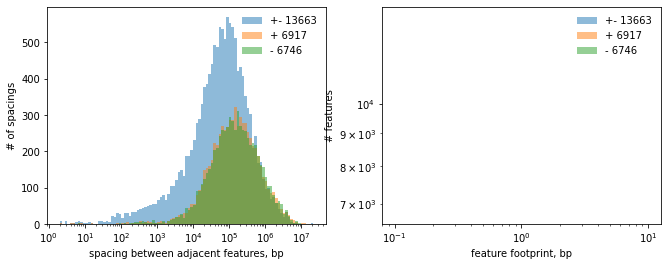

In [52]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros({"+-":df,
                               "+":df[df["strand"]=="+"],
                               "-":df[df["strand"]=="-"]
                               })

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 13663 -> 13663


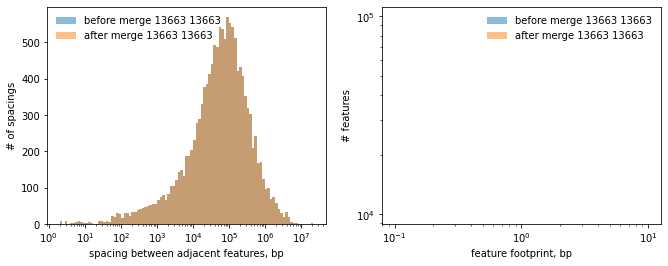

In [53]:
merge_radius = 100
# df_merged = bf.merge(df, min_dist=merge_radius)
df_merged = df

plot_spacing_footprint_distros({
    f"before merge {len(df)}":df,
    f"after merge {len(df_merged)}":df_merged,
})

print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [54]:
#let's describe our samples that we want to have in Figure 1 ...
# "ddx_CTCF","ddx_noCTCF"
# plot_samples = ['ddx_CTCF','ddx_noCTCF','taf5l_CTCF','taf5l_noCTCF','input_CTCF','input_noCTCF',"ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf"]
plot_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","h3k4_k562","polII","h3k4_r1","mrna_ctcf","mrna_noctcf"]
# CTCF/RAD21/ins/G4-seq/RNApolII/H3K4
titles = plot_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in plot_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [55]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan  )

stacking up ctcf ...
CPU times: user 2.52 s, sys: 189 ms, total: 2.71 s
Wall time: 2.7 s
stacking up noctcf ...
CPU times: user 2.43 s, sys: 184 ms, total: 2.61 s
Wall time: 2.6 s
stacking up rad21_CTCF ...
CPU times: user 2.67 s, sys: 204 ms, total: 2.88 s
Wall time: 2.86 s
stacking up rad21_noCTCF ...
CPU times: user 2.2 s, sys: 208 ms, total: 2.41 s
Wall time: 2.4 s
stacking up ins_CTCF ...
CPU times: user 1.96 s, sys: 124 ms, total: 2.08 s
Wall time: 2.07 s
stacking up ins_noCTCF ...
CPU times: user 1.91 s, sys: 192 ms, total: 2.1 s
Wall time: 2.13 s
stacking up G4a_r2 ...
CPU times: user 3.39 s, sys: 153 ms, total: 3.54 s
Wall time: 3.52 s
stacking up h3k4_k562 ...
CPU times: user 3.63 s, sys: 257 ms, total: 3.89 s
Wall time: 3.88 s
stacking up polII ...
CPU times: user 2.06 s, sys: 120 ms, total: 2.18 s
Wall time: 2.17 s
stacking up h3k4_r1 ...
CPU times: user 3.15 s, sys: 200 ms, total: 3.35 s
Wall time: 3.33 s
stacking up mrna_ctcf ...
CPU times: user 2.6 s, sys: 208 ms, total:

In [56]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
aaa = rstacks(
    "pcgene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "pcgene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

In [57]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "ncgene"
aaa = rstacks(
    "ncgene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "ncgene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

In [58]:
# turn G4-seq signal into stackup via bigBed:
annot_flank = 5_000
annot_binsize = 200
feat_name = "g4seq"
aaa = rstacks(
    "G4_polstall.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [59]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
normalize_insulation_stackups_INPLACE(
    stackups_set = stackups,
    ins_keys = insulation_keys
)

# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [61]:
length, width = stackups['G4a_r2'].shape
center_bin = int(width/2)

stackups['K4_mean'] = np.nanmean(stackups['h3k4_r1'][:,center_bin-3:center_bin+3],axis=1)

initial_index = np.arange( len(stackups['h3k4_r1']) )
ks = [('K4_mean', "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, stackups, verbose=True)
#stackups['K4_mean'][jjj]

sorting 13663 elements of K4_mean into 1 groups ...


### let's perform a scientific selection of the number of active TSS - as a "place" where K4_mean signal drops from to None ...

this can be done by averaging K4 over different number of bins around TSS - we concluded that -1,+1 (2 bins-wide) is too narrow, and +/-3 and +/-2 are very similar, "reliable" and smooth - and we chose +/-3 (6-200bp bins wide) for the downstream analysis ...

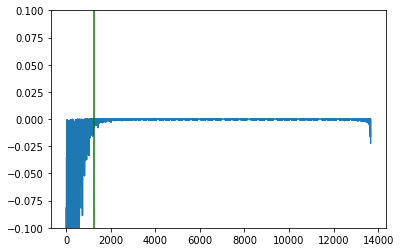

In [64]:
plt.plot(np.diff(stackups['K4_mean'][jjj]))
# print(np.diff(stackups['K4_mean'][jjj])[5000:17000].argmin())
ax = plt.gca()
ax.set_ylim(-0.1,0.1)
ax.axvline(1250,color="green")
number_TTS_near_TSS = 1250

In [65]:
for s in ["h3k4_k562",]:
    limss[s] = (1.,120)

In [66]:
# #
# # skipping this for now ....
# #
CHUNK_SIZE = 100

# G4_polstall
index_chunks = chunked(df.loc[jjj].index, CHUNK_SIZE)
G4p_sorted = []
Number_of_chunks = 0
_df2 = G4_plus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4p_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1

# G4_polstall
index_chunks = chunked(df.loc[jjj].index, CHUNK_SIZE)
G4m_sorted = []
Number_of_chunks = 0
_df2 = G4_minus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4m_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1

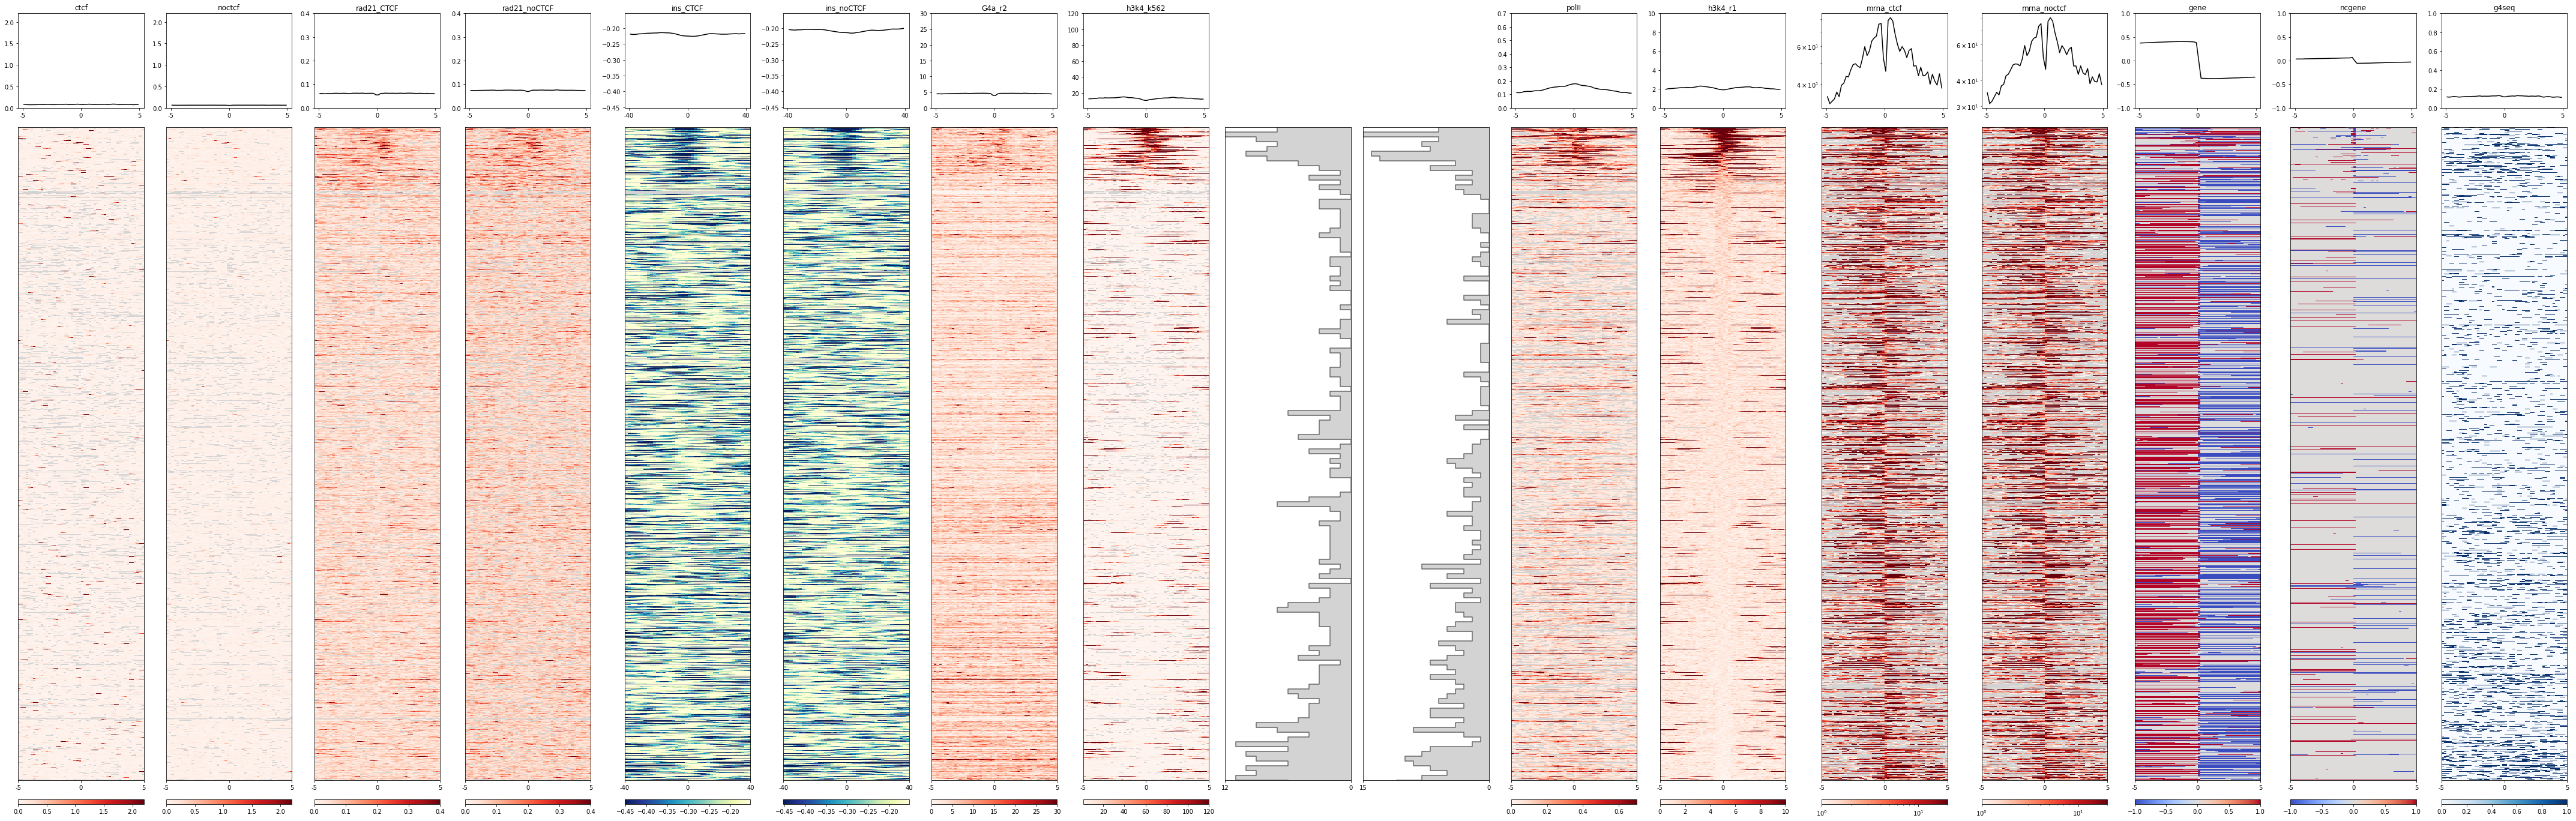

In [67]:
hmss = [ stackups[_k][jjj] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]


extra_order = [8,9]
hmss_order = [0,1,2,3,4,5,6,7,10,11,12,13,14,15,16]
assert len(hmss_order) == len(plot_samples)
# xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# # xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
                                    (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
    common_width_max = max(width)
    _y = np.arange(y)
    _width = width
    _color = color
    xtra_axs[col_index].step(_width,_y,color="dimgray")
    xtra_axs[col_index].fill_betweenx(_y,0,_width,color=_color,step="post")
    xtra_axs[col_index].invert_yaxis()
    xtra_axs[col_index].invert_xaxis()
    xtra_axs[col_index].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
    xtra_axs[col_index].set_ylim(max(_y), 0)
    xtra_axs[col_index].set_xlim(common_width_max,0)
    xtra_axs[col_index].set_yticks([])
    xtra_axs[col_index].set_yticklabels([])   
    xtra_axs[col_index].set_xticks([])
    xtra_axs[col_index].set_xticklabels([])   
    xtra_axs[col_index].set_xticks([common_width_max,0])
    xtra_axs[col_index].set_xticklabels([common_width_max,0])


sorting 12413 elements of ctcf into 1 groups ...


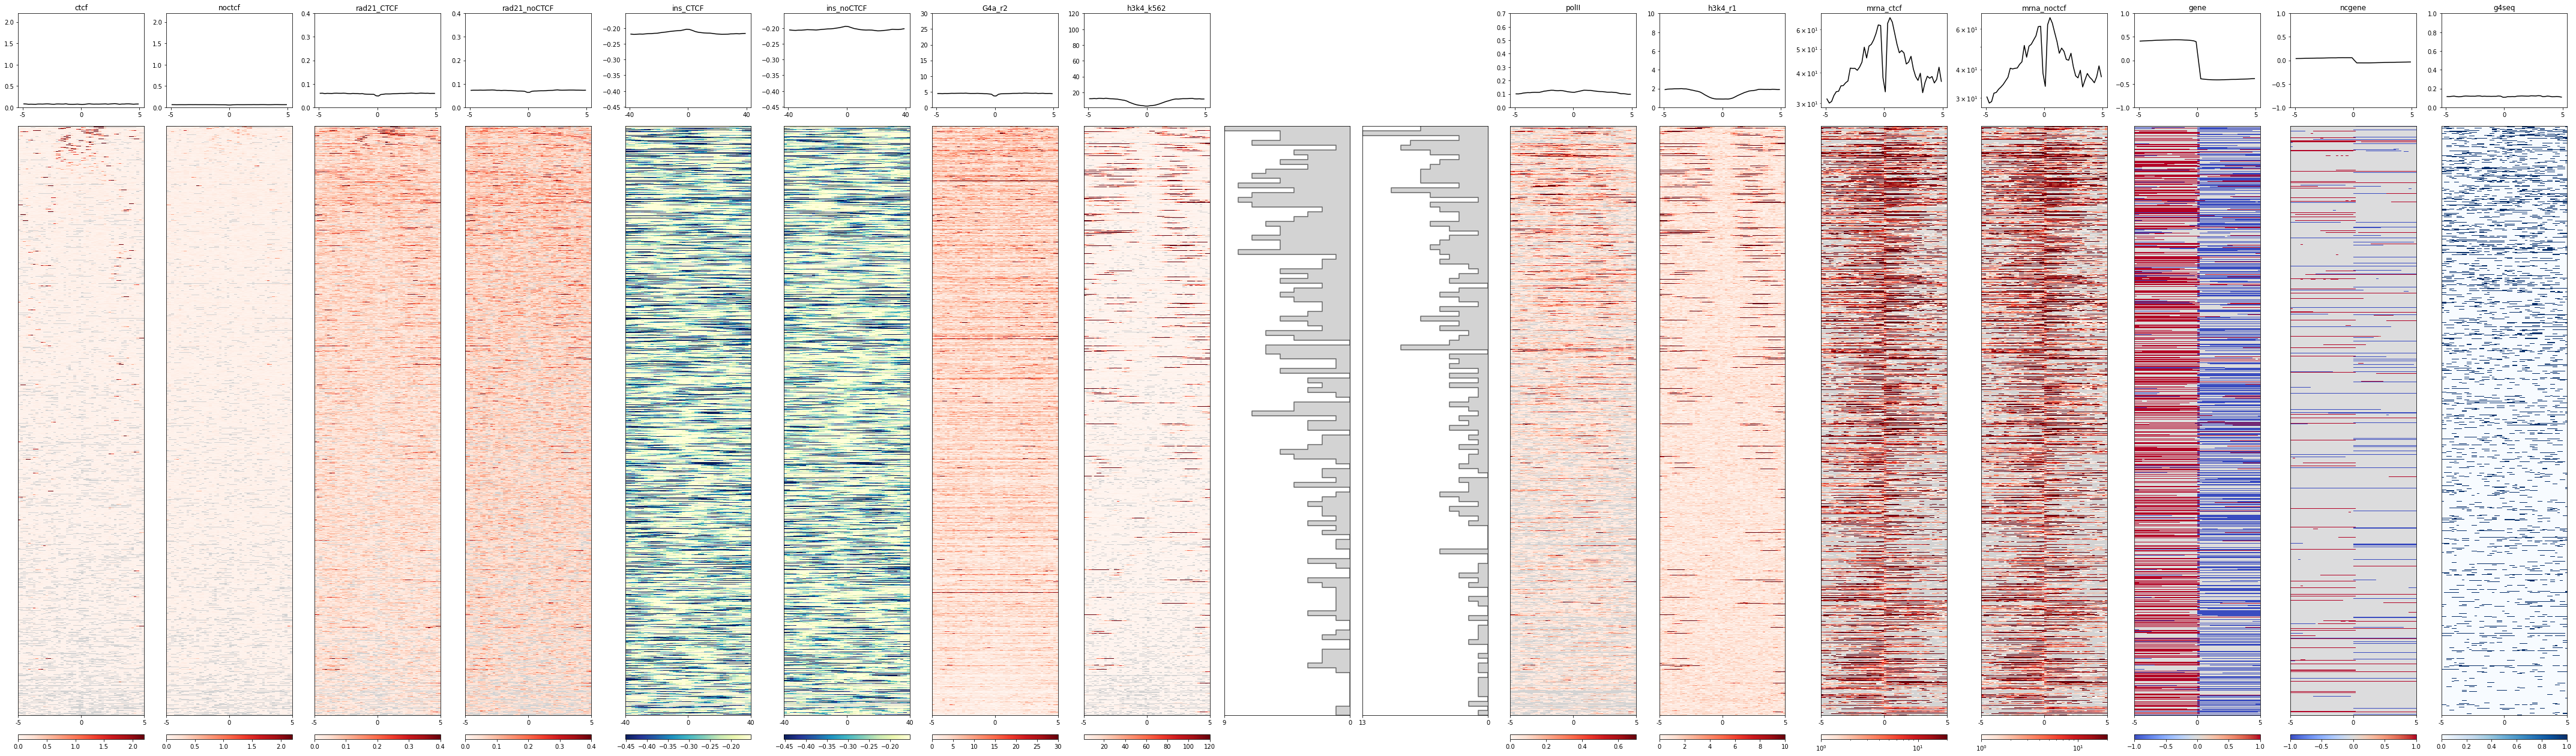

In [80]:
# let's take TTS of active genes, without H3K4 nearby ...
iii = jjj[number_TTS_near_TSS:]

_l, _w = stackups['ctcf'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['ctcf'] = np.nanmean(stackups['ctcf'][iii,_cent-10:_cent+10],axis=1)

ks = [('ctcf', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

#######################################################################
CHUNK_SIZE = 100

# G4_polstall
index_chunks = chunked(df.loc[iii[iii_reord]].index, CHUNK_SIZE)
G4p_sorted = []
Number_of_chunks = 0
_df2 = G4_plus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4p_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1

# G4_polstall
index_chunks = chunked(df.loc[iii[iii_reord]].index, CHUNK_SIZE)
G4m_sorted = []
Number_of_chunks = 0
_df2 = G4_minus_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4m_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    Number_of_chunks += 1
#######################################################################

hmss = [ stackups[_k][iii[iii_reord]] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]

extra_order = [8,9]
hmss_order = [0,1,2,3,4,5,6,7,10,11,12,13,14,15,16]
assert len(hmss_order) == len(plot_samples)

# plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="Fig1_masterlist_CTCFindep.pdf",fillmissing=False,interpolation="nearest")
# # plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
# df_merged.loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFindependent.bed",sep="\t",index=False,header=False)
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
                                    (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
    common_width_max = max(width)
    _y = np.arange(y)
    _width = width
    _color = color
    xtra_axs[col_index].step(_width,_y,color="dimgray")
    xtra_axs[col_index].fill_betweenx(_y,0,_width,color=_color,step="post")
    xtra_axs[col_index].invert_yaxis()
    xtra_axs[col_index].invert_xaxis()
    xtra_axs[col_index].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
    xtra_axs[col_index].set_ylim(max(_y), 0)
    xtra_axs[col_index].set_xlim(common_width_max,0)
    xtra_axs[col_index].set_yticks([])
    xtra_axs[col_index].set_yticklabels([])   
    xtra_axs[col_index].set_xticks([])
    xtra_axs[col_index].set_xticklabels([])   
    xtra_axs[col_index].set_xticks([common_width_max,0])
    xtra_axs[col_index].set_xticklabels([common_width_max,0])

# plt.savefig("ActiveTTS_HAP1.pdf")

### Creating a list of active TSSs - regardless of CTCF (preserve strand info !)

In [69]:
# save list of TTSs of active genes that do not have H3K4 nearby  :
ddf = df.loc[jjj[number_TTS_near_TSS:]].reset_index(drop=True)
fname = f"ActiveTTS-withoutH3K4-1bp.bed"
ddf.to_csv(fname,index=False,header=None,sep="\t")
print(f"Active TTS without H3K4 are saved to {fname} ...")

Active TTS without H3K4 are saved to ActiveTTS-withoutH3K4-1bp.bed ...


### Creating a list of active TSSs without CTCF around it ...

In [73]:
from copy import copy

In [74]:
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge", # just our NT CTCF ChipSeq peaks ...
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)

In [75]:
# using existing list of active TTSswithout H3K4 - we expand them by 2kb on each side ... -> ddf_exp
ddf = ddf.sort_values(["chrom","start"])
_ddf = copy(ddf.reset_index(drop=True))
ddf_exp = bioframe.expand(_ddf,pad=2_000)

In [76]:
# then overlap expanded TTS with CTCF -peaks, to find TTS without CTCF nearby ...
ddf_exp_ctcf = bioframe.overlap(ddf_exp,ctcf_df,how="left",suffixes=('','_')) # keep all TTS
# peek those, without CTCF 
_mask_TTS_without_CTCF = pd.isnull( ddf_exp_ctcf["chrom_"] )
ddf_exp_noctcf = ddf_exp_ctcf[_mask_TTS_without_CTCF][["chrom","start","end","strand"]]
ddf_exp_noctcf = ddf_exp_noctcf.astype({"start":int,"end":int})
# there shouldn't be any duplicates, but just in case ...
ddf_exp_noctcf = ddf_exp_noctcf.drop_duplicates().reset_index(drop=True)
print(len(ddf_exp_noctcf))

# now let's undo "expand" in a an easiest way - expand with a negative pad = -2000 ...
ddf_exp_noctcf = bioframe.expand(ddf_exp_noctcf, pad=-2_000)
# make footprints are unique ! - all has to be 1 bp!
print((ddf_exp_noctcf["end"]-ddf_exp_noctcf["start"]).value_counts())
# save it ...
fname = f"ActiveTTS-withoutH3K4-NO-CTCF-{len(ddf_exp_noctcf)}-1bp.bed"
ddf_exp_noctcf.to_csv(fname, index=False, header=None, sep="\t")
print(f"saving Active TTS without CTCF nearby to {fname}")

10933
1    10933
dtype: int64
saving Active TTS without CTCF nearby to ActiveTTS-withoutH3K4-NO-CTCF-10933-1bp.bed


In [204]:
# xxx = bioframe.overlap(ddf_exp_noctcf,ddf,how="left",suffixes=('1','2'))[["chrom1","start1","end1","strand1"]].drop_duplicates()
# xxx
# # xxx[~pd.isnull(xxx["chrom2"])][["chrom1","start1","end1","strand1"]].drop_duplicates()

In [203]:
# !scp ActiveTSS-11000-5bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp ActiveTSS-NO-CTCF-5bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS_HAP1-G4sorted.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/